In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm
import os


In [2]:
dataset_path = 'NDD_DATASET'  # Replace with your dataset path
full_dataset = datasets.ImageFolder(
    root=dataset_path,
    transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
)

In [3]:
# Calculate mean and std
loader = DataLoader(full_dataset, batch_size=64, shuffle=False, num_workers=2)
mean = 0.0
std = 0.0
for images, _ in tqdm(loader):
    batch_samples = images.size(0)  # batch size
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
full_dataset = images
mean /= len(full_dataset)
std /= len(full_dataset)
print(f"Calculated Mean: {mean}, Std: {std}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.42it/s]

Calculated Mean: tensor([42.1030, 42.1030, 42.1030]), Std: tensor([51.0259, 51.0259, 51.0259])


In [4]:
data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [5]:
full_dataset = datasets.ImageFolder(root=dataset_path, transform=data_transforms)


In [6]:
# Split dataset into train, validation, and test (80:10:10)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

In [7]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

In [8]:
# Self ATT

In [9]:
# class SelfAttention(nn.Module):
#     def __init__(self, in_channels):
#         super(SelfAttention, self).__init__()
#         self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
#         self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
#         self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
#         self.gamma = nn.Parameter(torch.zeros(1))  # Trainable scaling factor

#     def forward(self, x):
#         B, C, H, W = x.size()
#         query = self.query_conv(x).view(B, -1, H * W).permute(0, 2, 1)  # B x HW x C'
#         key = self.key_conv(x).view(B, -1, H * W)  # B x C' x HW
#         attention = torch.softmax(torch.bmm(query, key) / (H * W), dim=-1)  # B x HW x HW
#         value = self.value_conv(x).view(B, -1, H * W)  # B x C x HW
#         out = torch.bmm(value, attention.permute(0, 2, 1)).view(B, C, H, W)  # B x C x H x W
#         return self.gamma * out + x  # Residual connection
import torch
import torch.nn as nn
import torch.nn.functional as F

class MRI_SelfAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(MRI_SelfAttention, self).__init__()
        # Channel Attention
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global average pooling
            nn.Conv2d(channels, channels // reduction, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, kernel_size=1),
            nn.Sigmoid()
        )

        # Spatial Attention
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=7, padding=3),  # Aggregating spatial importance
            nn.Sigmoid()
        )

    def forward(self, x):
        # Channel Attention
        ca = self.channel_attention(x)
        x = x * ca

        # Spatial Attention
        spatial_avg = torch.mean(x, dim=1, keepdim=True)
        spatial_max, _ = torch.max(x, dim=1, keepdim=True)
        sa = self.spatial_attention(torch.cat([spatial_avg, spatial_max], dim=1))
        x = x * sa

        return x


In [12]:
class CNNModelWithSelfAttention(nn.Module):
    def __init__(self):
        super(CNNModelWithSelfAttention, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # Change input channels to 1
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            MRI_SelfAttention(512)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(401408, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 3)  # 3 classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [13]:
# Initialize the model
num_classes = 3
model = CNNModelWithSelfAttention()


In [14]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Early stopping parameters
patience = 3
best_val_loss = float('inf')
patience_counter = 0

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


CNNModelWithSelfAttention(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): MRI_SelfAttention(
      (channel_attention): Sequential(
        (0): AdaptiveAvgPool2d(output_size=1)
        (1): Conv2d(512

Epoch 1/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:30<00:00, 25.11it/s]


Train Loss: 0.6723, Train Accuracy: 64.16%
Val Loss: 0.5313, Val Accuracy: 73.39%
Validation loss decreased (inf → 0.5313). Saving model...
Epoch 2/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 26.10it/s]


Train Loss: 0.5089, Train Accuracy: 73.47%
Val Loss: 0.4191, Val Accuracy: 81.03%
Validation loss decreased (0.5313 → 0.4191). Saving model...
Epoch 3/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 25.93it/s]


Train Loss: 0.4359, Train Accuracy: 78.56%
Val Loss: 0.4131, Val Accuracy: 79.58%
Validation loss decreased (0.4191 → 0.4131). Saving model...
Epoch 4/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 26.05it/s]


Train Loss: 0.4085, Train Accuracy: 79.94%
Val Loss: 0.3746, Val Accuracy: 83.53%
Validation loss decreased (0.4131 → 0.3746). Saving model...
Epoch 5/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 26.08it/s]


Train Loss: 0.3920, Train Accuracy: 80.71%
Val Loss: 0.3452, Val Accuracy: 84.06%
Validation loss decreased (0.3746 → 0.3452). Saving model...
Epoch 6/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 26.02it/s]


Train Loss: 0.3841, Train Accuracy: 80.55%
Val Loss: 0.3449, Val Accuracy: 84.85%
Validation loss decreased (0.3452 → 0.3449). Saving model...
Epoch 7/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 26.10it/s]


Train Loss: 0.3716, Train Accuracy: 81.54%
Val Loss: 0.3376, Val Accuracy: 85.11%
Validation loss decreased (0.3449 → 0.3376). Saving model...
Epoch 8/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:28<00:00, 26.20it/s]


Train Loss: 0.3579, Train Accuracy: 82.81%
Val Loss: 0.3178, Val Accuracy: 85.24%
Validation loss decreased (0.3376 → 0.3178). Saving model...
Epoch 9/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 26.06it/s]


Train Loss: 0.3497, Train Accuracy: 83.04%
Val Loss: 0.3109, Val Accuracy: 86.30%
Validation loss decreased (0.3178 → 0.3109). Saving model...
Epoch 10/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 26.17it/s]


Train Loss: 0.3434, Train Accuracy: 83.40%
Val Loss: 0.3066, Val Accuracy: 86.96%
Validation loss decreased (0.3109 → 0.3066). Saving model...
Epoch 11/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:28<00:00, 26.18it/s]


Train Loss: 0.3337, Train Accuracy: 84.06%
Val Loss: 0.2917, Val Accuracy: 87.22%
Validation loss decreased (0.3066 → 0.2917). Saving model...
Epoch 12/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 26.07it/s]


Train Loss: 0.3242, Train Accuracy: 84.54%
Val Loss: 0.3399, Val Accuracy: 82.48%
Patience Counter: 1
Epoch 13/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:28<00:00, 26.28it/s]


Train Loss: 0.3119, Train Accuracy: 85.10%
Val Loss: 0.2794, Val Accuracy: 87.62%
Validation loss decreased (0.2917 → 0.2794). Saving model...
Epoch 14/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 26.11it/s]


Train Loss: 0.3070, Train Accuracy: 85.92%
Val Loss: 0.2952, Val Accuracy: 86.43%
Patience Counter: 1
Epoch 15/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:28<00:00, 26.21it/s]


Train Loss: 0.2921, Train Accuracy: 86.74%
Val Loss: 0.2648, Val Accuracy: 87.75%
Validation loss decreased (0.2794 → 0.2648). Saving model...
Epoch 16/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 26.13it/s]


Train Loss: 0.2733, Train Accuracy: 86.99%
Val Loss: 0.2544, Val Accuracy: 88.14%
Validation loss decreased (0.2648 → 0.2544). Saving model...
Epoch 17/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 26.17it/s]


Train Loss: 0.2595, Train Accuracy: 88.06%
Val Loss: 0.2531, Val Accuracy: 88.93%
Validation loss decreased (0.2544 → 0.2531). Saving model...
Epoch 18/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:28<00:00, 26.20it/s]


Train Loss: 0.2479, Train Accuracy: 88.59%
Val Loss: 0.2376, Val Accuracy: 88.80%
Validation loss decreased (0.2531 → 0.2376). Saving model...
Epoch 19/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 26.12it/s]


Train Loss: 0.2322, Train Accuracy: 89.89%
Val Loss: 0.2292, Val Accuracy: 89.46%
Validation loss decreased (0.2376 → 0.2292). Saving model...
Epoch 20/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 26.13it/s]


Train Loss: 0.2171, Train Accuracy: 90.58%
Val Loss: 0.2235, Val Accuracy: 90.12%
Validation loss decreased (0.2292 → 0.2235). Saving model...
Epoch 21/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 26.11it/s]


Train Loss: 0.1972, Train Accuracy: 91.49%
Val Loss: 0.2366, Val Accuracy: 89.06%
Patience Counter: 1
Epoch 22/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 26.14it/s]


Train Loss: 0.1782, Train Accuracy: 92.62%
Val Loss: 0.2038, Val Accuracy: 90.51%
Validation loss decreased (0.2235 → 0.2038). Saving model...
Epoch 23/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 26.13it/s]


Train Loss: 0.1648, Train Accuracy: 93.12%
Val Loss: 0.1934, Val Accuracy: 91.17%
Validation loss decreased (0.2038 → 0.1934). Saving model...
Epoch 24/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 26.03it/s]


Train Loss: 0.1444, Train Accuracy: 94.57%
Val Loss: 0.1952, Val Accuracy: 92.75%
Patience Counter: 1
Epoch 25/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 26.06it/s]


Train Loss: 0.1251, Train Accuracy: 95.01%
Val Loss: 0.1667, Val Accuracy: 93.41%
Validation loss decreased (0.1934 → 0.1667). Saving model...
Epoch 26/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 25.93it/s]


Train Loss: 0.1075, Train Accuracy: 95.92%
Val Loss: 0.1531, Val Accuracy: 94.20%
Validation loss decreased (0.1667 → 0.1531). Saving model...
Epoch 27/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 26.13it/s]


Train Loss: 0.0877, Train Accuracy: 96.71%
Val Loss: 0.1398, Val Accuracy: 95.26%
Validation loss decreased (0.1531 → 0.1398). Saving model...
Epoch 28/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:28<00:00, 26.18it/s]


Train Loss: 0.0691, Train Accuracy: 97.35%
Val Loss: 0.1692, Val Accuracy: 93.68%
Patience Counter: 1
Epoch 29/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 26.16it/s]


Train Loss: 0.0595, Train Accuracy: 97.92%
Val Loss: 0.1560, Val Accuracy: 94.60%
Patience Counter: 2
Epoch 30/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:28<00:00, 26.19it/s]


Train Loss: 0.0477, Train Accuracy: 98.27%
Val Loss: 0.1369, Val Accuracy: 96.18%
Validation loss decreased (0.1398 → 0.1369). Saving model...
Epoch 31/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:28<00:00, 26.20it/s]


Train Loss: 0.0410, Train Accuracy: 98.57%
Val Loss: 0.1230, Val Accuracy: 95.65%
Validation loss decreased (0.1369 → 0.1230). Saving model...
Epoch 32/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 26.17it/s]


Train Loss: 0.0372, Train Accuracy: 98.72%
Val Loss: 0.1538, Val Accuracy: 95.65%
Patience Counter: 1
Epoch 33/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:28<00:00, 26.18it/s]


Train Loss: 0.0257, Train Accuracy: 99.08%
Val Loss: 0.1109, Val Accuracy: 96.71%
Validation loss decreased (0.1230 → 0.1109). Saving model...
Epoch 34/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 25.97it/s]


Train Loss: 0.0235, Train Accuracy: 99.26%
Val Loss: 0.1320, Val Accuracy: 96.31%
Patience Counter: 1
Epoch 35/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:28<00:00, 26.19it/s]


Train Loss: 0.0204, Train Accuracy: 99.32%
Val Loss: 0.1079, Val Accuracy: 97.10%
Validation loss decreased (0.1109 → 0.1079). Saving model...
Epoch 36/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 26.13it/s]


Train Loss: 0.0212, Train Accuracy: 99.21%
Val Loss: 0.1554, Val Accuracy: 96.31%
Patience Counter: 1
Epoch 37/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 26.07it/s]


Train Loss: 0.0156, Train Accuracy: 99.57%
Val Loss: 0.1425, Val Accuracy: 97.23%
Patience Counter: 2
Epoch 38/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 26.03it/s]


Train Loss: 0.0076, Train Accuracy: 99.79%
Val Loss: 0.1194, Val Accuracy: 97.50%
Patience Counter: 3
Epoch 39/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 26.01it/s]


Train Loss: 0.0188, Train Accuracy: 99.34%
Val Loss: 0.1308, Val Accuracy: 97.23%
Patience Counter: 4
Epoch 40/100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:29<00:00, 26.13it/s]


Train Loss: 0.0042, Train Accuracy: 99.90%
Val Loss: 0.1112, Val Accuracy: 97.76%
Patience Counter: 5
Early stopping triggered!


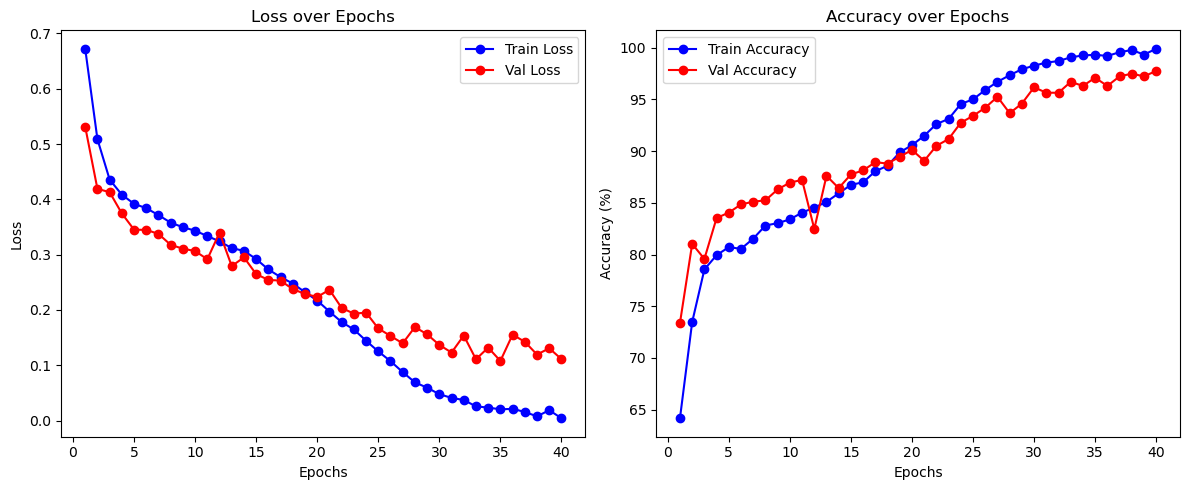

In [15]:
import matplotlib.pyplot as plt

best_model_path = "best_cnn2_self_model.pth"
num_epochs = 100

# Initialize lists to store loss and accuracy values for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_loss = float('inf')  # Initialize best validation loss for early stopping
patience_counter = 0
patience = 5  # Number of epochs to wait before early stopping

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train_samples = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    train_loss /= len(train_loader)
    train_accuracy = train_correct / total_train_samples * 100

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val_samples = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            total_val_samples += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = val_correct / total_val_samples * 100

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Store loss and accuracy values for plotting
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Early stopping
    if val_loss < best_val_loss:
        print(f"Validation loss decreased ({best_val_loss:.4f} → {val_loss:.4f}). Saving model...")
        torch.save(model.state_dict(), best_model_path)
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"Patience Counter: {patience_counter}")

    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

# Plotting the loss and accuracy curves
epochs = range(1, epoch + 2)  # epochs will be from 1 to final epoch

# Plot loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", color='blue', marker='o')
plt.plot(epochs, val_losses, label="Val Loss", color='red', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy", color='blue', marker='o')
plt.plot(epochs, val_accuracies, label="Val Accuracy", color='red', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
model.load_state_dict(torch.load('best_cnn2_self_model.pth'))
model.eval()

/tmp/ipykernel_3729626/4031370267.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_cnn2_self_model.pth'))


CNNModelWithSelfAttention(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): MRI_SelfAttention(
      (channel_attention): Sequential(
        (0): AdaptiveAvgPool2d(output_size=1)
        (1): Conv2d(512

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


In [18]:
# Initialize variables for metrics
test_loss = 0.0
test_correct = 0
total_test_samples = 0
all_labels = []
all_predictions = []

# Testing phase
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Predictions and accuracy
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        total_test_samples += labels.size(0)

        # Collect labels and predictions for metrics
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate average test loss and accuracy
test_loss /= len(test_loader)
test_accuracy = test_correct / total_test_samples * 100

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}%")


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:01<00:00, 63.98it/s]

Test Loss: 0.1003
Test Accuracy: 97.1053%



Classification Report:
              precision    recall  f1-score   support

  alzheimers       0.94      0.98      0.96       247
      normal       0.98      0.94      0.96       268
  parkinsons       1.00      0.99      1.00       245

    accuracy                           0.97       760
   macro avg       0.97      0.97      0.97       760
weighted avg       0.97      0.97      0.97       760


Confusion Matrix:
[[243   4   0]
 [ 16 252   0]
 [  0   2 243]]


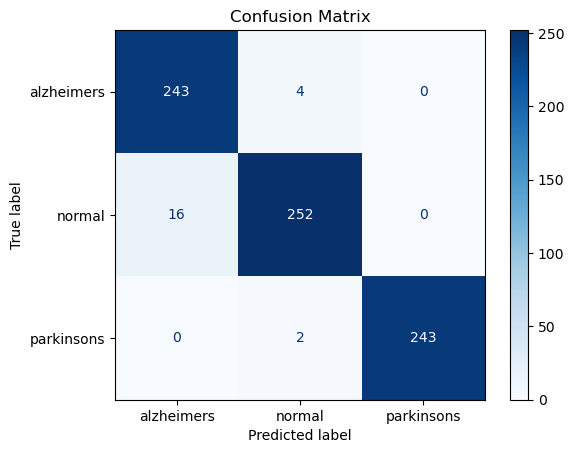

In [19]:
# Classification Report

print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=['alzheimers', 'normal', 'parkinsons']))

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['alzheimers', 'normal', 'parkinsons'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()